In [723]:
from gymnasium import Env
from gymnasium.spaces import Box, Dict, Discrete
import random
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import networkx as nx
from copy import copy
import ray

In [635]:
class Architecture:
    def __init__(self):
        self.c_capacity, self.s_capacity = 50, 2
        self.weights = [0.0125, 0.0010, 0.0200, 0.5000] # REVIEW
        self.lifetime = {0: 1, 1: 2, 2: 3, 3: 10}   # REVIEW
        self.max_actions = 10
        self.num_c = 2
        self.num_s = 6
        self.max_actions = 10
        self.min_free_space = 0.2
        self.space_flag = -1

        self.data_types = []
        self.data_allocation = []
        self.data_times = []

        self.data = {}
        self.devices = {}
        self.latencies = {}
        self.max_latencies = {}

        self.action_device = []
        self.action_type = []

        for j in (range(len(self.weights))):
            self.data[j] = {}
            for i in range(self.num_s+self.num_c):
                self.data[j][i] = 0
                self.devices[i] = {0: 0, 1: 0, 2: 0, 3: 0}
                self.latencies[i] = {}
                self.max_latencies[i] = {}

        for i in self.latencies.keys():
            for j in self.latencies.keys():
                self.latencies[i][j] = 0
                self.max_latencies[i][j] = 0

        devices = list(self.devices.keys())
        bound = round(len(self.devices)/4)
        self.clusters = {
            0: devices[bound*3:],
            1: devices[bound:bound*2],
            2: devices[bound*2:bound*3],
            3: devices[:bound]
        }
        self.visualization()

    def construct_dictionaries(self):
        for i in self.data:
            for j in self.data[i]:
                self.data[i][j] = 0
        for i in self.devices:
            for j in self.devices[i]:
                self.devices[i][j] = 0
        for device, d_type in zip(self.data_allocation, self.data_types):
            self.data[d_type][device] += 1
            self.devices[device][d_type] += 1

    def update(self, data_type, device):
        self.data_types.append(data_type)
        self.data_allocation.append(device)
        self.data_times.append(0)
        self.devices[device][data_type] += 1
        self.data[data_type][device] += 1

    def heart_beat(self):
        deads = []
        for i in range(len(self.data_times)):
            self.data_times[i] += 1
            if self.data_times[i] == self.lifetime[self.data_types[i]]:
                deads.append(i)

        removed = 0
        for i in deads:
            self.devices[self.data_allocation[i-removed]][self.data_types[i-removed]] -= 1
            self.data[self.data_types[i-removed]][self.data_allocation[i-removed]] -= 1
            self.data_types.pop(i - removed)
            self.data_allocation.pop(i - removed)
            self.data_times.pop(i - removed)
            removed += 1

    def free_space(self):
        load = {}
        for i in range(self.num_c + self.num_s):
            if i < self.num_c:
                load[i] = (self.c_capacity - sum([a*b for a,b in zip(list(self.devices[i].values()), self.weights)]))/self.c_capacity
            else:
                load[i] = (self.s_capacity - sum([a*b for a,b in zip(list(self.devices[i].values()), self.weights)]))/self.s_capacity
            if load[i] <= self.min_free_space:
                self.space_flag = i
        return load

    def reduce_type(self, data_type):
        max_time = 0
        positions = []
        for i in range(len(self.data_allocation)):
            if self.data_types[i] == data_type:
                if self.data_times[i] > max_time:
                    max_time = self.data_times[i]
                    positions = []
                    positions.append(i)
                elif self.data_times[i] == max_time:
                    positions.append(i)

        removed = 0
        for i in positions:
            self.devices[self.data_allocation[i-removed]][self.data_types[i-removed]] -= 1
            self.data[self.data_types[i-removed]][self.data_allocation[i-removed]] -= 1
            self.data_times.pop(i - removed)
            self.data_types.pop(i - removed)
            self.data_allocation.pop(i -removed)
            removed += 1

    def check_quantity(self, data_type):
        if data_type != 3:
            if sum(list(self.data[data_type].values())) > 2*(self.num_s + self.num_c):
                self.reduce_type(data_type)
        else:
            if sum(list(self.data[data_type].values())) > 2*self.num_s:
                self.reduce_type(data_type)

    def visualization(self):
        keys = list(self.devices.keys())
        cs = keys[:self.num_c]
        ss = keys[self.num_c:]

        colors = []
        sizes = []

        graph = nx.Graph()

        colors.append('lightblue')
        sizes.append(1000)
        index = 0
        for i in range(len(cs)):
            if i != len(cs)-1:
                colors.append('lightblue')
                sizes.append(1000)
                graph.add_edge(cs[i],cs[i+1])
                graph.add_weighted_edges_from([(cs[i],cs[i+1],10)])
                for j in range(int(len(ss)/self.num_c)):
                    colors.append('orange')
                    sizes.append(100)
                    graph.add_edge(cs[i],ss[index])
                    graph.add_weighted_edges_from([(cs[i],ss[index],6)])
                    index += 1
            else:
                graph.add_edge(cs[i],cs[0])
                graph.add_weighted_edges_from([(cs[i],cs[0],10)])
                for j in range(int(len(ss)/self.num_c)+len(ss)%self.num_c):
                    graph.add_edge(cs[i],ss[index])
                    graph.add_weighted_edges_from([(cs[i],ss[index],6)])
                    colors.append('orange')
                    sizes.append(100)
                    index += 1

        pos = nx.spring_layout(graph)  # Position nodes using a spring layout algorithm
        # nx.draw(graph, pos, with_labels=True, node_size=sizes, node_color=colors, font_weight=12, font_color='black', edge_color='gray')
        edge_labels = nx.get_edge_attributes(graph, 'weight')
        # nx.draw_networkx_edge_labels(graph, pos, edge_labels=edge_labels)

        # plt.title("Architecture:")
        # plt.axis('off')
        # plt.show()

        for u in graph.nodes:
            shortest_paths = nx.shortest_path_length(graph, source=u, weight='weight')
            for v, weight in shortest_paths.items():
                self.latencies[u][v] = weight

        max_latency = self.latencies[self.num_c][self.num_c+self.num_s-1]
        for i in self.max_latencies.keys():
            for j in self.max_latencies[i].keys():
                self.max_latencies[i][j] = max_latency

    def compute_total_latency(self):
        total_latency = 0
        for i in range(len(self.action_type)):
            total_latency += sum([a*b for a,b in zip(self.data[self.action_type[i]].values(), self.latencies[self.action_device[i]].values())])
        return total_latency

    def compute_normalized_latency(self):
        total_latency = 0
        max_latency = 0
        for i in range(len(self.action_type)):
            total_latency += sum([a*b for a,b in zip(self.data[self.action_type[i]].values(), self.latencies[self.action_device[i]].values())])
            max_latency += sum([a*b for a,b in zip(self.data[self.action_type[i]].values(), self.max_latencies[self.action_device[i]].values())])
        return total_latency/(max_latency+1)

    def rl_update(self, new_allocation):
        self.data_allocation = new_allocation
        self.construct_dictionaries()
        return self.free_space()

    def generate(self, operation):
        if operation == 0 or operation == 1 or operation == 2:
            for i in range(self.num_s + self.num_c):
                self.update(operation,i)
            self.check_quantity(operation)
        elif operation == 3:
            for i in range(self.num_c,(self.num_c + self.num_s)):
                self.update(operation,i)
            self.check_quantity(operation)
        else:
            device=self.clusters[operation - 10][0]
            self.action_device.append(device)
            self.action_type.append(operation-10)
            difference = len(self.action_device) - self.max_actions
            if difference >= 0:
                for i in range(difference):
                    self.action_device.pop(0)
                    self.action_type.pop(0)

    def round_robin(self):
        allocation_round = []
        capacities = [50,50,2,2,2,2,2,2]
        index = 0
        server_index = 0
        for i in range(len(self.data_allocation)):
            if index == self.num_c + self.num_s:
                index = 0
            if (index != 0 or index != 1) and capacities[index] - self.weights[self.data_types[i]] <= 0.2 * 2:
                allocation_round.append(server_index)
                capacities[server_index] -= self.weights[self.data_types[i]]
                server_index = 1 if server_index == 0 else 0
            else:
                allocation_round.append(index)
                capacities[index] -= self.weights[self.data_types[i]]
                index += 1
        self.data_allocation = allocation_round.copy()
        self.construct_dictionaries()
        for i in range(52 - len(allocation_round)):      # REMEMBER TO CHANGE !!!!!!!!!!!!!!
            allocation_round.append(random.randint(0,self.num_c+self.num_s-1))
        return allocation_round

    def greedy_server(self):
        allocation_greedy= []
        index = 0
        for i in range(len(self.data_allocation)):
            allocation_greedy.append(index)
            index = 1 if index == 0 else 0
        self.data_allocation = allocation_greedy.copy()
        self.construct_dictionaries()
        for i in range(52 - len(allocation_greedy)):      # REMEMBER TO CHANGE !!!!!!!!!!!!!!
            allocation_greedy.append(random.randint(0,self.num_c+self.num_s-1))
        return allocation_greedy

    def greedy_algorithm(self):
        if self.space_flag == -1:
            # print("It's ok")
            allocation = []
            for i in self.data_types:
                allocation.append(random.sample(list(self.clusters[i]),1)[0])
            self.data_allocation = allocation.copy()
            self.construct_dictionaries()
            for i in range(52 - len(allocation)):      # REMEMBER TO CHANGE !!!!!!!!!!!!!!
                allocation.append(random.randint(0,self.num_c+self.num_s-1))
            return allocation
        else:
            # print("Problem")
            problematic_key = None
            for key, value in self.clusters.items():
                if self.space_flag in value:
                    problematic_key = key
                    break
            for i in range(self.num_c):
                self.clusters[problematic_key].append(i)
            self.space_flag = -1
            return self.greedy_algorithm()

In [5]:
executions = [[0,1,2,10],
              [0,1,2,11],
              [0,1,2,12],
              [0,1,2,3],
              [0,1,2,10],
              [0,1,2,11],
              [0,1,2,12],
              [0,1,2,3],
              [0,1,2,13]]
architecture = Architecture()

for i in range(3):
    for j in executions:
        architecture.heart_beat()
        for h in j:
            architecture.generate(h)
        print(1-architecture.compute_normalized_latency())
        architecture.round_robin()
        print(1-architecture.compute_normalized_latency())

0.3931034482758621
0.3931034482758621
0.5011547344110854
0.5011547344110854
0.5228848821081831
0.5228848821081831
0.5228848821081831
0.5228848821081831
0.500578034682081
0.500578034682081
0.5143104943625325
0.5143104943625325
0.5225537820957669
0.5225537820957669
0.5225537820957669
0.5225537820957669
0.49909474954737476
0.5111647555823777
0.501388117712382
0.49028317601332594
0.4992819530876017
0.5088559119195788
0.5145140933950357
0.5061001262095077
0.5103071098022718
0.5145140933950357
0.5145140933950357
0.5061001262095077
0.5061001262095077
0.5145140933950357
0.5145140933950357
0.5061001262095077
0.5103071098022718
0.5145140933950357
0.5149040424663127
0.49857084524295636
0.4845986984815618
0.5019522776572668
0.5019522776572668
0.4845986984815618
0.5061001262095077
0.5145140933950357
0.5069415229280606
0.5061001262095077
0.5061001262095077
0.5145140933950357
0.5145140933950357
0.5061001262095077
0.5061001262095077
0.5145140933950357
0.5069415229280606
0.5061001262095077
0.4985708452

In [636]:
class AcesArchitectureEnv(Env):
    def __init__(self, maximum_data):
        self.architecture = Architecture()
        self.executions = [[0,1,2,10],
                           [0,1,2,11],
                           [0,1,2,12],
                           [0,1,2,3],
                           [0,1,2,10],
                           [0,1,2,11],
                           [0,1,2,12],
                           [0,1,2,3],
                           [0,1,2,13]]
        self.execution_index = 0
        self.num_devices = len(self.architecture.devices.keys())
        self.maximum_data = maximum_data

        self.weights = self.architecture.weights
        self.allocation = self.architecture.data_allocation
        self.data_types = self.architecture.data_types
        self.free_space = list(self.architecture.free_space().values())
        self.last_calls_type = self.architecture.action_type
        self.last_calls_device = self.architecture.action_device

        self.observation_space = Dict({
            "weights": Box(low=0, high=1, shape=(4,), dtype=np.float32),
            "allocation": Box(low=-1, high=self.num_devices-1, shape=(maximum_data,), dtype=np.int32),
            "data_type": Box(low=-1, high=3, shape=(maximum_data,), dtype=np.int32),
            "free_space": Box(low=-10, high=1, shape=(self.num_devices,), dtype=np.float32),
            "last_calls_type": Box(low=-1, high=13, shape=(10,), dtype=np.int32),
            "last_calls_device": Box(low=-1, high=self.num_devices-1, shape=(10,), dtype=np.int32)
        })

        self.action_space = Box(low=0, high=self.num_devices-1, shape=(maximum_data,), dtype=np.int32)

        self.allocation_length = len(self.allocation)

        self.reward = 0

    def get_obs(self):

        return {
            "weights": np.array(self.weights),
            "allocation": np.array(self.allocation),
            "data_type": np.array(self.data_types),
            "free_space": np.array(self.free_space),
            "last_calls_type": np.array(self.last_calls_type),
            "last_calls_device": np.array(self.last_calls_device)
        }

    def step(self,action):
        self.architecture.data_allocation = list(action[:self.allocation_length])
        self.allocation[:self.allocation_length] = list(action[:self.allocation_length])
        self.architecture.construct_dictionaries()
        normalized_latency = self.architecture.compute_normalized_latency()
        # normalized_latency = 0
        self.free_space = list(self.architecture.free_space().values())

        # flag = False
        # for i in self.free_space:
        #     if i <= self.architecture.min_free_space:
        #         flag = True
        #         break
        #
        # if flag:
        #     self.reward = -3
        # else:
        #     w1 = 2
        #     w2 = 1
        #     std = np.std(self.free_space)
        #     self.reward = w1*(1 - normalized_latency) + w2*(1-std)
        self.reward = (1 - normalized_latency)

        done = True
        info = {}

        return self.get_obs(), self.reward, done, info

    def reset(self):
        if self.reward < 0:
            return self.get_obs()
        else:
            self.architecture.heart_beat()
            for execution in self.executions[self.execution_index]:
                self.architecture.generate(execution)
            self.allocation = self.architecture.data_allocation.copy()
            self.data_types = self.architecture.data_types.copy()
            self.allocation_length = len(self.allocation)
            for minus_one in range(self.maximum_data - len(self.allocation)):
                self.allocation.append(-1)
                self.data_types.append(-1)
            self.free_space = list(self.architecture.free_space().values())
            self.last_calls_type = self.architecture.action_type.copy()
            self.last_calls_device = self.architecture.action_device.copy()
            for minus_one in range(10 - len(self.last_calls_type)):
                self.last_calls_type.append(-1)
                self.last_calls_device.append(-1)

            self.execution_index = self.execution_index +1 if self.execution_index <= len(self.executions) - 2 else 0
            return self.get_obs()

    def close(self):
        print('CLOSED')

In [637]:
from ray.tune.registry import register_env
from gymnasium.wrappers import EnvCompatibility
from ray.rllib.algorithms.impala import ImpalaConfig
from ray.rllib.algorithms.ppo import PPOConfig
from gymnasium.wrappers import TimeLimit
import ray

ray.shutdown()

architecture = Architecture()

def env_creator(env_config):
    return TimeLimit(EnvCompatibility(AcesArchitectureEnv(52)), max_episode_steps=10)
register_env("AcesArchitectureEnv", env_creator)

config = (
    ImpalaConfig()
    .environment("AcesArchitectureEnv",disable_env_checking=True)
    .rollouts(num_rollout_workers=40,
              num_envs_per_worker=5) # Max = 60
    .resources(num_gpus=0,
               num_cpus_per_worker=1)
    .training(entropy_coeff=0.02)
)
# config['model']['vf_share_layers'] = False
config["model"]["fcnet_hiddens"] =[64,64]

# algorithm = config.build()
# algorithm.set_weights(algorithm_bc.get_weights())
# checkpoint_path = algorithm.save()
# print(checkpoint_path)
algorithm_latency = config.build()
# algorithm.restore("./TFM/algorithms/online_offline_1400/checkpoint_001477")

result =[]

for j in tqdm(range(150)):
    result_train = algorithm_latency.train()["episode_reward_mean"]
    result.append(result_train)
    # if (j%10 == 0):
    print(result_train)
print(result)

2023-06-09 15:59:05,697	INFO worker.py:1553 -- Started a local Ray instance.


KeyboardInterrupt: 

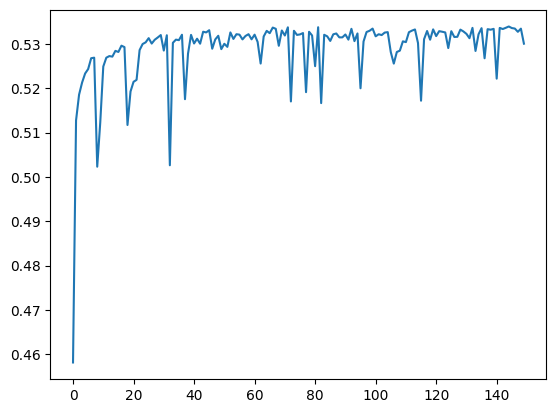

In [445]:
plt.plot(result)

In [446]:
test_architecture = AcesArchitectureEnv(52)

In [541]:
obs = test_architecture.reset()
action = algorithm_latency.compute_single_action(obs)
test_architecture.step(action)

({'weights': array([0.0125, 0.001 , 0.02  , 0.5   ]),
  'allocation': array([5, 5, 6, 5, 2, 3, 2, 2, 0, 0, 0, 4, 7, 3, 0, 2, 2, 7, 4, 0, 4, 1,
         0, 3, 7, 0, 7, 5, 6, 1, 7, 4, 0, 4, 3, 4, 7, 5, 2, 3, 0, 3, 0, 4,
         0, 1, 5, 7, 4, 2, 4, 0], dtype=int32),
  'data_type': array([3, 3, 3, 3, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2,
         0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2,
         2, 2, 3, 3, 3, 3, 3, 3]),
  'free_space': array([ 0.98742,  0.99895,  0.469  ,  0.72275,  0.468  , -0.00675,
          0.74375,  0.726  ]),
  'last_calls_type': array([0, 1, 2, 0, 1, 2, 3, 0, 1, 2]),
  'last_calls_device': array([6, 2, 4, 6, 2, 4, 0, 6, 2, 4])},
 0.5574253260412285,
 True,
 {})

In [542]:
print(test_architecture.architecture.compute_total_latency())
print(1-test_architecture.architecture.compute_normalized_latency())
# print(np.std(test_architecture.free_space))
# print("Reward: {}".format(1-np.std(test_architecture.free_space)))
test_architecture.architecture.greedy_server()
print(test_architecture.architecture.compute_total_latency())
print(1-test_architecture.architecture.compute_normalized_latency())
test_architecture.architecture.round_robin()
print(test_architecture.architecture.compute_total_latency())
print(1-test_architecture.architecture.compute_normalized_latency())
# print(1-np.std(list(test_architecture.architecture.free_space().values())))

1052
0.5574253260412285
1140
0.5204038704249053
1402
0.41018090029448884


In [ ]:
class AcesWeightedArchitectureEnv(Env):
    def __init__(self, maximum_data):
        self.architecture = Architecture()
        self.executions = [[0,1,2,10],
                           [0,1,2,11],
                           [0,1,2,12],
                           [0,1,2,3],
                           [0,1,2,10],
                           [0,1,2,11],
                           [0,1,2,12],
                           [0,1,2,3],
                           [0,1,2,13]]
        self.execution_index = 0
        self.num_devices = len(self.architecture.devices.keys())
        self.maximum_data = maximum_data

        self.weights = self.architecture.weights
        self.allocation = self.architecture.data_allocation
        self.data_types = self.architecture.data_types
        self.free_space = list(self.architecture.free_space().values())
        self.last_calls_type = self.architecture.action_type
        self.last_calls_device = self.architecture.action_device

        self.observation_space = Dict({
            "weights": Box(low=0, high=1, shape=(4,), dtype=np.float32),
            "allocation": Box(low=-1, high=self.num_devices-1, shape=(maximum_data,), dtype=np.int32),
            "data_type": Box(low=-1, high=3, shape=(maximum_data,), dtype=np.int32),
            "free_space": Box(low=-10, high=1, shape=(self.num_devices,), dtype=np.float32),
            "last_calls_type": Box(low=-1, high=13, shape=(10,), dtype=np.int32),
            "last_calls_device": Box(low=-1, high=self.num_devices-1, shape=(10,), dtype=np.int32)
        })

        self.action_space = Box(low=0, high=self.num_devices-1, shape=(maximum_data,), dtype=np.int32)

        self.allocation_length = len(self.allocation)

        self.reward = 0

    def get_obs(self):

        return {
            "weights": np.array(self.weights),
            "allocation": np.array(self.allocation),
            "data_type": np.array(self.data_types),
            "free_space": np.array(self.free_space),
            "last_calls_type": np.array(self.last_calls_type),
            "last_calls_device": np.array(self.last_calls_device)
        }

    def step(self,action):
        self.architecture.data_allocation = list(action[:self.allocation_length])
        self.allocation[:self.allocation_length] = list(action[:self.allocation_length])
        self.architecture.construct_dictionaries()
        normalized_latency = self.architecture.compute_normalized_latency()
        self.free_space = list(self.architecture.free_space().values())

        flag = False
        for space in self.free_space:
            if space <= self.architecture.min_free_space:
                flag = True
                break

        if flag:
            self.reward = -1
        else:
            w1 = 1
            w2 = 0
            std = np.std(self.free_space)
            self.reward = w1*(1 - normalized_latency) + w2*(1-std)
        # self.reward = (1 - normalized_latency)

        done = True
        info = {}

        return self.get_obs(), self.reward, done, info

    def reset(self):
        if self.reward < 0:
            return self.get_obs()
        else:
            self.architecture.heart_beat()
            for execution in self.executions[self.execution_index]:
                self.architecture.generate(execution)
            self.allocation = self.architecture.data_allocation.copy()
            self.data_types = self.architecture.data_types.copy()
            self.allocation_length = len(self.allocation)
            for minus_one in range(self.maximum_data - len(self.allocation)):
                self.allocation.append(-1)
                self.data_types.append(-1)
            self.free_space = list(self.architecture.free_space().values())
            self.last_calls_type = self.architecture.action_type.copy()
            self.last_calls_device = self.architecture.action_device.copy()
            for minus_one in range(10 - len(self.last_calls_type)):
                self.last_calls_type.append(-1)
                self.last_calls_device.append(-1)

            self.execution_index = self.execution_index +1 if self.execution_index <= len(self.executions) - 2 else 0
            return self.get_obs()

    def close(self):
        print('CLOSED')

In [ ]:
from ray.tune.registry import register_env
from gymnasium.wrappers import EnvCompatibility
from ray.rllib.algorithms.impala import ImpalaConfig
from gymnasium.wrappers import TimeLimit
import ray

ray.shutdown()

def env_creator(env_config):
    return TimeLimit(EnvCompatibility(AcesWeightedArchitectureEnv(52)), max_episode_steps=10)
register_env("AcesWeightedArchitectureEnv", env_creator)

config = (
    ImpalaConfig()
    .environment("AcesWeightedArchitectureEnv",disable_env_checking=True)
    .rollouts(num_rollout_workers=40,
              num_envs_per_worker=5) # Max = 60
    .resources(num_gpus=0,
               num_cpus_per_worker=1)
    .training(entropy_coeff=0.02)
    .offline_data(output="TFM/datasets/imapala50")
)
# config['model']['vf_share_layers'] = False
config["model"]["fcnet_hiddens"] =[64,64]

# algorithm = config.build()
# algorithm.set_weights(algorithm_bc.get_weights())
# checkpoint_path = algorithm.save()
# print(checkpoint_path)
algorithm_weighted = config.build()
# algorithm.restore("./TFM/algorithms/online_offline_1400/checkpoint_001477")

result_weighted =[]

for j in tqdm(range(50)):
    result_train = algorithm_weighted.train()["episode_reward_mean"]
    result_weighted.append(result_train)
    # if (j%50== 0):
    print(result_train)
print(result_weighted)

2023-06-09 18:59:59,937	INFO worker.py:1553 -- Started a local Ray instance.
2023-06-09 19:00:18,398	INFO trainable.py:172 -- Trainable.setup took 21.243 seconds. If your trainable is slow to initialize, consider setting reuse_actors=True to reduce actor creation overheads.
2023-06-09 19:00:18,400	WARNING util.py:67 -- Install gputil for GPU system monitoring.
  2%|██▎                                                                                                               | 1/50 [00:14<11:27, 14.02s/it]

0.11974051244906482


  4%|████▌                                                                                                             | 2/50 [00:30<12:11, 15.23s/it]

0.3632478801347752


  6%|██████▊                                                                                                           | 3/50 [00:45<12:06, 15.47s/it]

0.3906351610263017


  8%|█████████                                                                                                         | 4/50 [01:01<12:02, 15.70s/it]

0.4063153777531562


 10%|███████████▍                                                                                                      | 5/50 [01:16<11:24, 15.22s/it]

0.41376144416444405


 12%|█████████████▋                                                                                                    | 6/50 [01:31<11:15, 15.36s/it]

0.40776792455831234


 14%|███████████████▉                                                                                                  | 7/50 [01:47<11:01, 15.38s/it]

0.37717692465012953


 16%|██████████████████▏                                                                                               | 8/50 [02:02<10:48, 15.45s/it]

0.3941501793405564


 18%|████████████████████▌                                                                                             | 9/50 [02:17<10:19, 15.10s/it]

0.4225277684823769


 20%|██████████████████████▌                                                                                          | 10/50 [02:32<10:06, 15.17s/it]

0.4035151302774821


 22%|████████████████████████▊                                                                                        | 11/50 [02:48<10:02, 15.44s/it]

0.42188106225876865


 24%|███████████████████████████                                                                                      | 12/50 [03:04<09:49, 15.52s/it]

0.40820290903379075


 26%|█████████████████████████████▍                                                                                   | 13/50 [03:18<09:20, 15.16s/it]

0.4219647703460298


 28%|███████████████████████████████▋                                                                                 | 14/50 [03:34<09:10, 15.30s/it]

0.4219257704755235


 30%|█████████████████████████████████▉                                                                               | 15/50 [03:49<08:56, 15.34s/it]

0.409462502993706


 32%|████████████████████████████████████▏                                                                            | 16/50 [04:05<08:46, 15.49s/it]

0.4260740520602995


 34%|██████████████████████████████████████▍                                                                          | 17/50 [04:21<08:40, 15.77s/it]

0.42561628944015484


 36%|████████████████████████████████████████▋                                                                        | 18/50 [04:36<08:11, 15.35s/it]

0.4283831995618442


 38%|██████████████████████████████████████████▉                                                                      | 19/50 [04:52<07:59, 15.46s/it]

0.4228953544239139


 40%|█████████████████████████████████████████████▏                                                                   | 20/50 [05:07<07:45, 15.52s/it]

0.43047186091552253


 42%|███████████████████████████████████████████████▍                                                                 | 21/50 [05:22<07:22, 15.26s/it]

0.39783771245508964


 44%|█████████████████████████████████████████████████▋                                                               | 22/50 [05:38<07:11, 15.42s/it]

0.4291992431530129


 46%|███████████████████████████████████████████████████▉                                                             | 23/50 [05:53<06:58, 15.50s/it]

0.4326209925598977


 48%|██████████████████████████████████████████████████████▏                                                          | 24/50 [06:09<06:45, 15.60s/it]

0.4015317300860514


 50%|████████████████████████████████████████████████████████▌                                                        | 25/50 [06:25<06:32, 15.70s/it]

0.4317420646315559


 52%|██████████████████████████████████████████████████████████▊                                                      | 26/50 [06:40<06:07, 15.33s/it]

0.4124055262260388


 54%|█████████████████████████████████████████████████████████████                                                    | 27/50 [06:55<05:56, 15.48s/it]

0.42855459822758574


 56%|███████████████████████████████████████████████████████████████▎                                                 | 28/50 [07:11<05:44, 15.64s/it]

0.42692546066473874


In [727]:
from ray.rllib.algorithms.bc import BCConfig
import ray
from ray.tune.registry import register_env
from gymnasium.wrappers import EnvCompatibility
from gymnasium.wrappers import TimeLimit
from ray.rllib.utils.test_utils import check_train_results

ray.shutdown()

def env_creator(env_config):
    return TimeLimit(EnvCompatibility(AcesWeightedArchitectureEnv(52)), max_episode_steps=10)
register_env("AcesWeightedArchitectureEnv", env_creator)
path = "TFM/datasets/imapala50"

config_bc = (
    BCConfig()
    .environment(env="AcesWeightedArchitectureEnv",disable_env_checking=True)
    .offline_data(input_=path)
    .training(
        train_batch_size=2,
        # twin_q=False,
    )
    .evaluation(
        evaluation_interval=5,
        evaluation_num_workers=1,
        evaluation_duration=5,
        evaluation_parallel_to_training=True,
        evaluation_config=BCConfig.overrides(input_="sampler"),
    )
    .rollouts(num_rollout_workers=1)
)
config_bc['model']['vf_share_layers'] = False
config_bc["model"]["fcnet_hiddens"] = [64,64]

algorithm_bc = config_bc.build()
for i in tqdm(range(10000)):
    result = algorithm_bc.train()
    check_train_results(result)
    # print(result)
    eval_results = result.get("evaluation")

2023-06-09 19:15:33,584	WARNING deprecation.py:50 -- DeprecationWarning: `MARWIL used to have off_policy_estimation_methods is and wis by default. This haschanged to off_policy_estimation_methods: \{\}.If you want to use an off-policy estimator, specify it in.evaluation(off_policy_estimation_methods=...)` has been deprecated. This will raise an error in the future!
2023-06-09 19:15:36,465	INFO worker.py:1553 -- Started a local Ray instance.
(RolloutWorker pid=2027016) 2023-06-09 19:15:43,583	WARNING json_reader.py:261 -- Treating input directory as glob patterns: ['/home/rcalzada/TFM/datasets/imapala50/*.json', '/home/rcalzada/TFM/datasets/imapala50/*.zip']
2023-06-09 19:15:45,988	WARNING json_reader.py:261 -- Treating input directory as glob patterns: ['/home/rcalzada/TFM/datasets/imapala50/*.json', '/home/rcalzada/TFM/datasets/imapala50/*.zip']
2023-06-09 19:15:51,075	INFO trainable.py:172 -- Trainable.setup took 17.476 seconds. If your trainable is slow to initialize, consider setti

In [731]:
from ray.tune.registry import register_env
from gymnasium.wrappers import EnvCompatibility
from ray.rllib.algorithms.impala import ImpalaConfig
from gymnasium.wrappers import TimeLimit
import ray

ray.shutdown()

def env_creator(env_config):
    return TimeLimit(EnvCompatibility(AcesWeightedArchitectureEnv(52)), max_episode_steps=10)
register_env("AcesWeightedArchitectureEnv", env_creator)

config = (
    ImpalaConfig()
    .environment("AcesWeightedArchitectureEnv",disable_env_checking=True)
    .rollouts(num_rollout_workers=30,
              num_envs_per_worker=5) # Max = 60
    .resources(num_gpus=0,
               num_cpus_per_worker=1)
    .training(entropy_coeff=0.02)
    .offline_data(output="TFM/datasets/imapala50")
)
config['model']['vf_share_layers'] = False
config["model"]["fcnet_hiddens"] =[64,64]

algorithm = config.build()
algorithm.set_weights(algorithm_bc.get_weights())
checkpoint_path = algorithm.save()
print(checkpoint_path)
algorithm_weighted = config.build()
# algorithm.restore("./TFM/algorithms/online_offline_1400/checkpoint_001477")

result_weighted =[]

for j in tqdm(range(50)):
    result_train = algorithm_weighted.train()["episode_reward_mean"]
    result_weighted.append(result_train)
    # if (j%50== 0):
    print(result_train)
print(result_weighted)

2023-06-09 21:37:07,321	INFO worker.py:1553 -- Started a local Ray instance.
2023-06-09 21:37:24,014	INFO trainable.py:172 -- Trainable.setup took 19.743 seconds. If your trainable is slow to initialize, consider setting reuse_actors=True to reduce actor creation overheads.
2023-06-09 21:37:24,016	WARNING util.py:67 -- Install gputil for GPU system monitoring.


/home/rcalzada/ray_results/Impala_AcesWeightedArchitectureEnv_2023-06-09_21-37-04o18rrb88/checkpoint_000000


2023-06-09 21:37:39,295	INFO trainable.py:172 -- Trainable.setup took 15.104 seconds. If your trainable is slow to initialize, consider setting reuse_actors=True to reduce actor creation overheads.
2023-06-09 21:37:39,297	WARNING util.py:67 -- Install gputil for GPU system monitoring.
  2%|██▎                                                                                                               | 1/50 [00:13<11:20, 13.88s/it]

0.10383328668480901


  4%|████▌                                                                                                             | 2/50 [00:29<12:01, 15.04s/it]

0.3553047463372978


  6%|██████▊                                                                                                           | 3/50 [00:43<11:18, 14.44s/it]

0.37815303766803193


  8%|█████████                                                                                                         | 4/50 [00:58<11:18, 14.75s/it]

0.39921978550671267


 10%|███████████▍                                                                                                      | 5/50 [01:12<10:49, 14.43s/it]

0.40879960052877873


 12%|█████████████▋                                                                                                    | 6/50 [01:27<10:48, 14.73s/it]

0.39988047072420774


 14%|███████████████▉                                                                                                  | 7/50 [01:43<10:49, 15.09s/it]

0.41900861817772916


 16%|██████████████████▏                                                                                               | 8/50 [01:57<10:18, 14.73s/it]

0.42150237267926555


 18%|████████████████████▌                                                                                             | 9/50 [02:13<10:12, 14.94s/it]

0.4265740305078653


 20%|██████████████████████▌                                                                                          | 10/50 [02:26<09:44, 14.62s/it]

0.40930518804047233


 22%|████████████████████████▊                                                                                        | 11/50 [02:42<09:38, 14.82s/it]

0.42987593089888165


 24%|███████████████████████████                                                                                      | 12/50 [02:56<09:15, 14.63s/it]

0.2926772416370629


 26%|█████████████████████████████▍                                                                                   | 13/50 [03:11<09:06, 14.78s/it]

0.4185046954938625


 28%|███████████████████████████████▋                                                                                 | 14/50 [03:26<08:55, 14.86s/it]

0.3750500619238434


 30%|█████████████████████████████████▉                                                                               | 15/50 [03:40<08:29, 14.57s/it]

0.2836715524396175


 32%|████████████████████████████████████▏                                                                            | 16/50 [03:55<08:24, 14.83s/it]

0.4103520625069426


 34%|██████████████████████████████████████▍                                                                          | 17/50 [04:09<07:58, 14.51s/it]

0.4272955249070326


 36%|████████████████████████████████████████▋                                                                        | 18/50 [04:25<07:52, 14.78s/it]

0.39617150554388175


 38%|██████████████████████████████████████████▉                                                                      | 19/50 [04:40<07:44, 15.00s/it]

0.361190437816217


Exception in thread Thread-9444:
Traceback (most recent call last):
  File "/usr/lib/python3.10/threading.py", line 1016, in _bootstrap_inner
    self.run()
  File "/home/rcalzada/.local/lib/python3.10/site-packages/ray/rllib/execution/learner_thread.py", line 74, in run
    self.step()
  File "/home/rcalzada/.local/lib/python3.10/site-packages/ray/rllib/execution/multi_gpu_learner_thread.py", line 143, in step
    buffer_idx, released = self.ready_tower_stacks_buffer.get()
  File "/home/rcalzada/.local/lib/python3.10/site-packages/ray/rllib/execution/minibatch_buffer.py", line 48, in get
    self.buffers[self.idx] = self.inqueue.get(timeout=self.timeout)
  File "/usr/lib/python3.10/queue.py", line 179, in get
    raise Empty
_queue.Empty
 40%|█████████████████████████████████████████████▏                                                                   | 20/50 [04:54<07:19, 14.66s/it]

0.43022479250615214


 42%|███████████████████████████████████████████████▍                                                                 | 21/50 [05:10<07:13, 14.95s/it]

0.42435999933497637


 44%|█████████████████████████████████████████████████▋                                                               | 22/50 [05:24<06:50, 14.65s/it]

0.4201972256497125


 46%|███████████████████████████████████████████████████▉                                                             | 23/50 [05:39<06:40, 14.83s/it]

0.44056816618202554


 48%|██████████████████████████████████████████████████████▏                                                          | 24/50 [05:53<06:19, 14.58s/it]

0.4143508816018613


 50%|████████████████████████████████████████████████████████▌                                                        | 25/50 [06:08<06:11, 14.86s/it]

0.42790066090962103


 52%|██████████████████████████████████████████████████████████▊                                                      | 26/50 [06:24<05:59, 14.98s/it]

0.3122450168141709


 54%|█████████████████████████████████████████████████████████████                                                    | 27/50 [06:37<05:36, 14.65s/it]

0.4211519538800378


 56%|███████████████████████████████████████████████████████████████▎                                                 | 28/50 [06:53<05:28, 14.92s/it]

0.43169716468104624


 58%|█████████████████████████████████████████████████████████████████▌                                               | 29/50 [07:07<05:07, 14.63s/it]

0.38555542743583127


 60%|███████████████████████████████████████████████████████████████████▊                                             | 30/50 [07:22<04:58, 14.90s/it]

0.3965928658087173


 62%|██████████████████████████████████████████████████████████████████████                                           | 31/50 [07:38<04:45, 15.03s/it]

0.41269056234504714


 64%|████████████████████████████████████████████████████████████████████████▎                                        | 32/50 [07:52<04:24, 14.71s/it]

0.4389926188960996


 66%|██████████████████████████████████████████████████████████████████████████▌                                      | 33/50 [08:07<04:12, 14.88s/it]

0.4400452723078034


 68%|████████████████████████████████████████████████████████████████████████████▊                                    | 34/50 [08:21<03:53, 14.61s/it]

0.3700365201981676


 70%|███████████████████████████████████████████████████████████████████████████████                                  | 35/50 [08:36<03:42, 14.80s/it]

0.42735743514941726


 72%|█████████████████████████████████████████████████████████████████████████████████▎                               | 36/50 [08:52<03:30, 15.02s/it]

0.42811063162350144


 74%|███████████████████████████████████████████████████████████████████████████████████▌                             | 37/50 [09:06<03:10, 14.67s/it]

0.43307692340454335


 76%|█████████████████████████████████████████████████████████████████████████████████████▉                           | 38/50 [09:21<02:58, 14.91s/it]

0.43293018022067364


 78%|████████████████████████████████████████████████████████████████████████████████████████▏                        | 39/50 [09:34<02:38, 14.43s/it]

0.4201285759383236


 80%|██████████████████████████████████████████████████████████████████████████████████████████▍                      | 40/50 [09:50<02:27, 14.73s/it]

0.42690351595477094


 82%|████████████████████████████████████████████████████████████████████████████████████████████▋                    | 41/50 [10:04<02:10, 14.50s/it]

0.4321414847912555


 84%|██████████████████████████████████████████████████████████████████████████████████████████████▉                  | 42/50 [10:19<01:57, 14.70s/it]

0.4397592408234912


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████▏               | 43/50 [10:33<01:41, 14.56s/it]

0.438103169416491


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████▍             | 44/50 [10:48<01:28, 14.72s/it]

0.4397633710868169


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 45/50 [11:04<01:14, 14.86s/it]

0.43363246697068275


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 46/50 [11:18<00:58, 14.63s/it]

0.4394436264779061


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 47/50 [11:33<00:44, 14.92s/it]

0.41585863110879184


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 48/50 [11:47<00:29, 14.62s/it]

0.4306926896271734


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 49/50 [12:02<00:14, 14.79s/it]

0.4360529475957365


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [12:16<00:00, 14.74s/it]

0.30828879740818466
[0.10383328668480901, 0.3553047463372978, 0.37815303766803193, 0.39921978550671267, 0.40879960052877873, 0.39988047072420774, 0.41900861817772916, 0.42150237267926555, 0.4265740305078653, 0.40930518804047233, 0.42987593089888165, 0.2926772416370629, 0.4185046954938625, 0.3750500619238434, 0.2836715524396175, 0.4103520625069426, 0.4272955249070326, 0.39617150554388175, 0.361190437816217, 0.43022479250615214, 0.42435999933497637, 0.4201972256497125, 0.44056816618202554, 0.4143508816018613, 0.42790066090962103, 0.3122450168141709, 0.4211519538800378, 0.43169716468104624, 0.38555542743583127, 0.3965928658087173, 0.41269056234504714, 0.4389926188960996, 0.4400452723078034, 0.3700365201981676, 0.42735743514941726, 0.42811063162350144, 0.43307692340454335, 0.43293018022067364, 0.4201285759383236, 0.42690351595477094, 0.4321414847912555, 0.4397592408234912, 0.438103169416491, 0.4397633710868169, 0.43363246697068275, 0.4394436264779061, 0.41585863110879184, 0.430692689627173

In [733]:
for j in tqdm(range(2000)):
    result_train = algorithm_weighted.train()["episode_reward_mean"]
    result_weighted.append(result_train)
    if (j%100== 0):
        print(result_train)

  0%|                                                                                                              | 1/2000 [00:15<8:22:31, 15.08s/it]

0.42698321082469143


  5%|█████▍                                                                                                      | 101/2000 [24:43<7:47:05, 14.76s/it]

0.4350999054708121


 10%|██████████▊                                                                                                 | 201/2000 [49:16<7:15:52, 14.54s/it]

0.43682828860810863


 15%|███████████████▉                                                                                          | 301/2000 [1:13:44<7:03:23, 14.95s/it]

0.4409959268115544


 20%|█████████████████████▎                                                                                    | 401/2000 [1:38:10<6:38:14, 14.94s/it]

0.43807195164699647


 25%|██████████████████████████▌                                                                               | 501/2000 [2:02:37<6:06:47, 14.68s/it]

0.44368266674424833


 30%|███████████████████████████████▊                                                                          | 601/2000 [2:27:04<5:40:08, 14.59s/it]

0.4457802792475778


 35%|█████████████████████████████████████▏                                                                    | 701/2000 [2:51:22<5:13:37, 14.49s/it]

0.4449641343675359


 37%|███████████████████████████████████████▍                                                                  | 743/2000 [3:01:41<5:09:55, 14.79s/it]2023-06-10 00:52:49,683	ERROR actor_manager.py:496 -- Ray error, taking actor 13 out of service. ray::RolloutWorker.apply() (pid=2087117, ip=138.4.11.229, repr=<ray.rllib.evaluation.rollout_worker.RolloutWorker object at 0x7f8ed3bc8ac0>)
  File "/home/rcalzada/.local/lib/python3.10/site-packages/ray/rllib/utils/actor_manager.py", line 183, in apply
    raise e
  File "/home/rcalzada/.local/lib/python3.10/site-packages/ray/rllib/utils/actor_manager.py", line 174, in apply
    return func(self, *args, **kwargs)
  File "/home/rcalzada/.local/lib/python3.10/site-packages/ray/rllib/algorithms/impala/impala.py", line 679, in <lambda>
    lambda worker: worker.sample(),
  File "/home/rcalzada/.local/lib/python3.10/site-packages/ray/rllib/evaluation/rollout_worker.py", line 946, in sample
    self.output_writer.write(batch)
  File "/home/rcalzada

RayTaskError(OSError): [36mray::RolloutWorker.apply()[39m (pid=2087117, ip=138.4.11.229, repr=<ray.rllib.evaluation.rollout_worker.RolloutWorker object at 0x7f8ed3bc8ac0>)
  File "/home/rcalzada/.local/lib/python3.10/site-packages/ray/rllib/utils/actor_manager.py", line 183, in apply
    raise e
  File "/home/rcalzada/.local/lib/python3.10/site-packages/ray/rllib/utils/actor_manager.py", line 174, in apply
    return func(self, *args, **kwargs)
  File "/home/rcalzada/.local/lib/python3.10/site-packages/ray/rllib/algorithms/impala/impala.py", line 679, in <lambda>
    lambda worker: worker.sample(),
  File "/home/rcalzada/.local/lib/python3.10/site-packages/ray/rllib/evaluation/rollout_worker.py", line 946, in sample
    self.output_writer.write(batch)
  File "/home/rcalzada/.local/lib/python3.10/site-packages/ray/rllib/offline/json_writer.py", line 76, in write
    f.write(data)
OSError: [Errno 28] No space left on device

The history saving thread hit an unexpected error (OperationalError('database or disk is full')).History will not be written to the database.


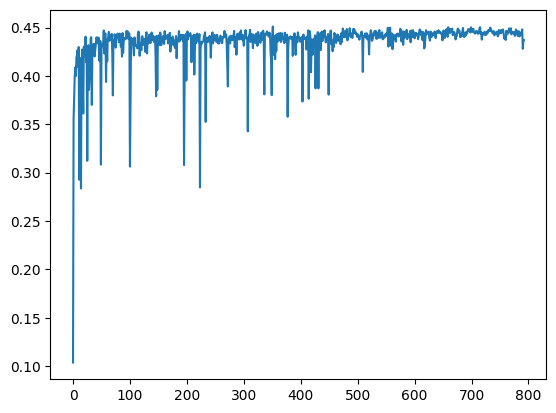

In [734]:
plt.plot(result_weighted)

In [735]:
# test_architecture = AcesArchitectureEnv(52)
test_weighted_architecture = AcesArchitectureEnv(52)

In [797]:
obs=test_weighted_architecture.reset()
# action = algorithm.compute_single_action(obs)
action_weighted = algorithm_weighted.compute_single_action(obs)
# print(test_architecture.step(action))
test_weighted_architecture.step(action_weighted)

({'weights': array([0.0125, 0.001 , 0.02  , 0.5   ]),
  'allocation': array([0, 0, 0, 6, 6, 2, 0, 5, 6, 0, 4, 0, 2, 4, 3, 0, 0, 2, 6, 3, 6, 7,
         1, 4, 4, 4, 3, 4, 7, 2, 7, 2, 1, 4, 5, 1, 4, 2, 1, 4, 0, 0, 2, 1,
         2, 2, 0, 7, 1, 2, 3, 0], dtype=int32),
  'data_type': array([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2,
         2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1,
         2, 2, 2, 2, 2, 2, 2, 2]),
  'free_space': array([0.93912, 0.99866, 0.7055 , 0.979  , 0.70225, 0.74375, 0.2395 ,
         0.9675 ]),
  'last_calls_type': array([0, 1, 2, 0, 1, 2, 3, 0, 1, 2]),
  'last_calls_device': array([6, 2, 4, 6, 2, 4, 0, 6, 2, 4])},
 0.538037865748709,
 True,
 {})

In [786]:
# print(test_architecture.architecture.compute_total_latency())
# print(1-test_architecture.architecture.compute_normalized_latency())
print(test_weighted_architecture.architecture.compute_total_latency())
# print(test_weighted_architecture.architecture.latencies)
# print(1-test_weighted_architecture.architecture.compute_normalized_latency())
test_weighted_architecture.architecture.round_robin()
# print(test_weighted_architecture.architecture.data_allocation)
# print(test_weighted_architecture.architecture.free_space())
# print(test_weighted_architecture.architecture.compute_total_latency())
print(1-test_weighted_architecture.architecture.compute_normalized_latency())
print("Reward: {}".format(1*(1-test_weighted_architecture.architecture.compute_normalized_latency())+0*(1-np.std(test_weighted_architecture.free_space))))
test_weighted_architecture.architecture.greedy_server()
print(test_weighted_architecture.architecture.compute_total_latency())
# print(1-test_weighted_architecture.architecture.compute_normalized_latency())
print("Reward: {}".format(1*(1-test_weighted_architecture.architecture.compute_normalized_latency())+0*(1-np.std(test_weighted_architecture.free_space))))

1298
0.4135605253816117
Reward: 0.4135605253816117
1264
Reward: 0.5512957046503373
